In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


流式输出内容被截断，只能显示最后 5000 行内容。
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train/PNEUMONIA/person499_bacteria_2103.jpeg
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train/PNEUMONIA/person280_bacteria_1318.jpeg
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train/PNEUMONIA/person55_bacteria_263.jpeg
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train/PNEUMONIA/person1353_virus_2333.jpeg
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train/PNEUMONIA/person1504_bacteria_3931.jpeg
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train/PNEUMONIA/person1011_bacteria_2942.jpeg
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:24<00:00, 100MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/kaggle'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q -o chest-xray-pneumonia.zip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:17<00:00, 116MB/s]
100% 2.29G/2.29G [00:17<00:00, 141MB/s]


In [ ]:
import torch
from torchvision import datasets, transforms

data_transforms = transforms.Compose([
    transforms.Resize(size=(56, 56)),
    transforms.ToTensor(),
])

# Set up the data directory
data_dir = "/content/chest_xray/chest_xray/"

# Load the datasets
train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms)
test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Create the model and optimizer
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
for epoch in range(3):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}]: Train Loss: {running_loss / len(train_loader):.4f}")

# Evaluate the model on the test set
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

Epoch [1]: Train Loss: 0.4252
Epoch [2]: Train Loss: 0.2267
Epoch [3]: Train Loss: 0.2028
Accuracy on the test set: 80.77%


In [ ]:
import torch
from torchvision import datasets, transforms

# Set up the data directory
data_dir = "/content/chest_xray/chest_xray/"

data_transforms = transforms.Compose([
    transforms.Resize(size=(56, 56)),
    transforms.ToTensor(),
])

# Load the datasets
train_dataset = datasets.ImageFolder(data_dir+"train/", transform=data_transforms)
test_dataset = datasets.ImageFolder(data_dir+"test/", transform=data_transforms)

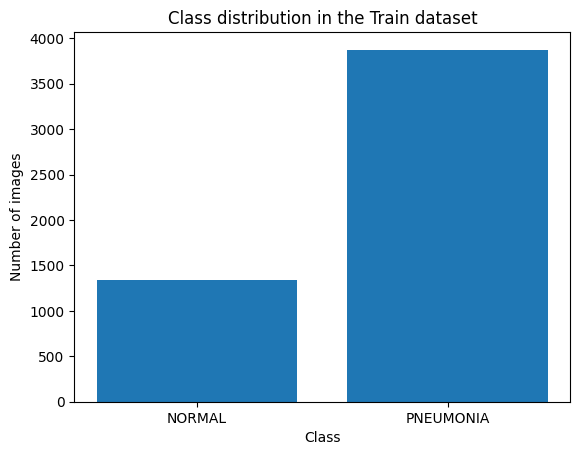

Train dataset mean: 0.4823, standard deviation: 0.2174


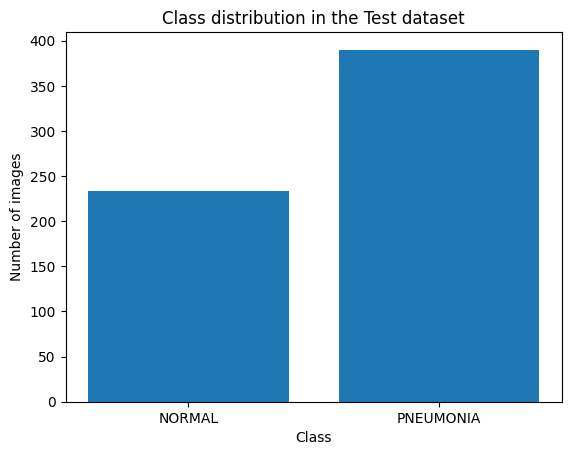

Test dataset mean: 0.4747, standard deviation: 0.2198


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_class_distribution(dataset, dataset_name):
    class_counts = np.zeros(len(dataset.classes))
    for _, y in dataset:
        class_counts[y] += 1

    plt.bar(dataset.classes, class_counts)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Class distribution in the {dataset_name} dataset")
    plt.show()

def calculate_dataset_stats(dataset):
    mean = 0.0
    std = 0.0
    for x, _ in dataset:
        mean += x.mean()
        std += x.std()

    mean /= len(dataset)
    std /= len(dataset)

    return mean.item(), std.item()

visualize_class_distribution(train_dataset, "Train")
mean, std = calculate_dataset_stats(train_dataset)
print(f"Train dataset mean: {mean:.4f}, standard deviation: {std:.4f}")

visualize_class_distribution(test_dataset, "Test")
mean, std = calculate_dataset_stats(test_dataset)
print(f"Test dataset mean: {mean:.4f}, standard deviation: {std:.4f}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize empty lists to store true labels and predictions
true_labels = []
predicted_labels = []
correct = 0

# Accumulate true labels and predictions for all mini-batches in the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {correct / len(test_dataset):.2%}")

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

Accuracy on the test set: 80.77%
Precision: 0.78, Recall: 0.96, F1 score: 0.86


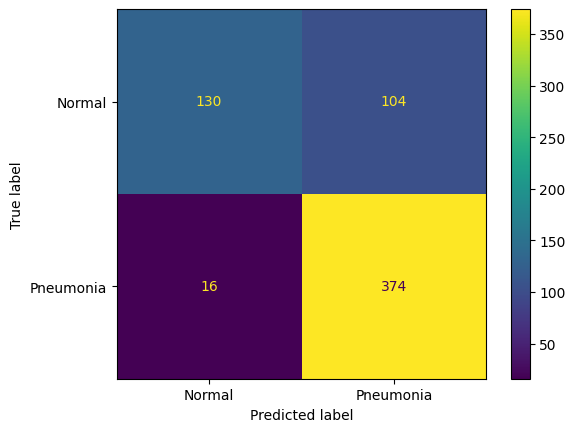

In [ ]:
# Add imports at the top
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()